<center><h1>Classification Tree and SVM Classifier</h1></center>

### 1. Data Exploration and Feature Engineering <a id='top'></a>

In this assignment we’ll be using several different models to predict Engine HP with some given features.

In [ ]:
# Imports
from google.colab import drive
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/data.csv")

#### a) Perform a thorough exploratory data analysis (EDA) on the dataset. Include advanced visualizations (e.g., pair plots, correlation heatmaps) and statistical summaries. Identify any anomalies or patterns. [0.5]

*Code in this section was partly retrieved from our Assignment 1, Tutorial 2, Tutorial 3, and Tutorial 5.*

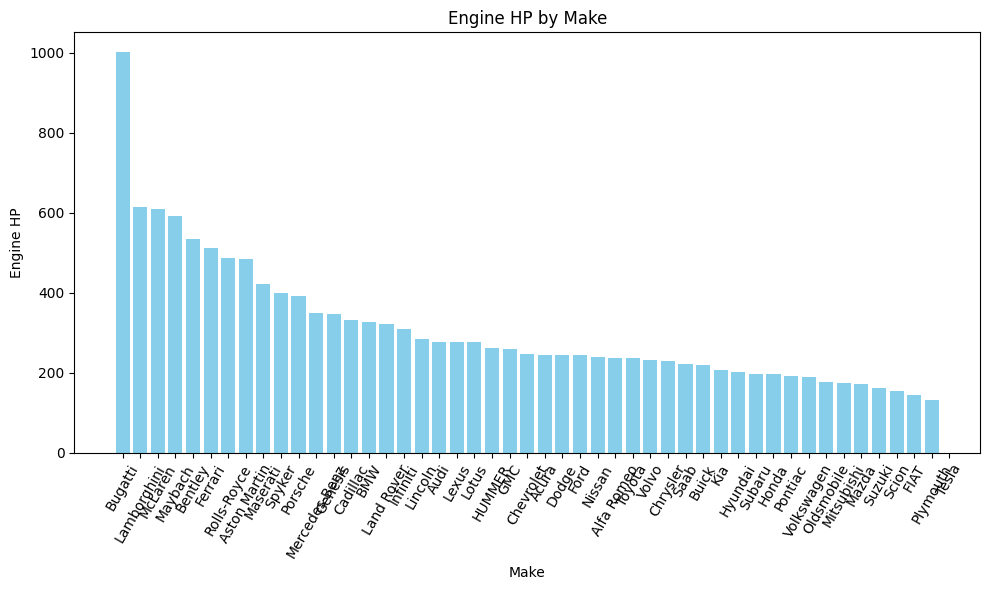

In [ ]:
group_data = df.groupby('Make')['Engine HP'].mean().reset_index()
group_data = group_data.sort_values(by='Engine HP', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(group_data['Make'], group_data['Engine HP'], color='skyblue')

plt.xlabel('Make')
plt.ylabel('Engine HP')
plt.title('Engine HP by Make')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

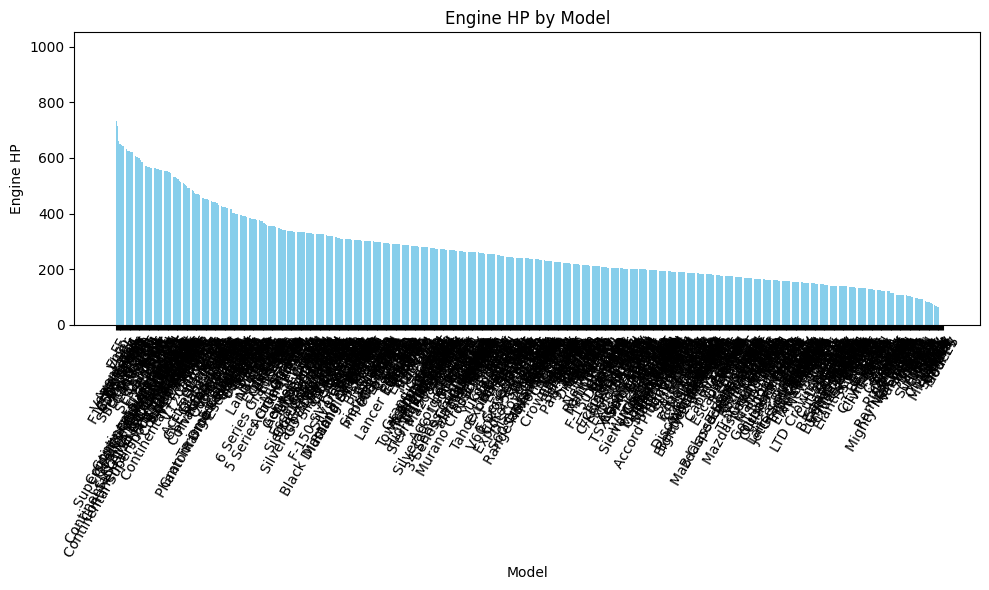

In [ ]:
group_data = df.groupby('Model')['Engine HP'].mean().reset_index()
group_data = group_data.sort_values(by='Engine HP', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(group_data['Model'], group_data['Engine HP'], color='skyblue')

plt.xlabel('Model')
plt.ylabel('Engine HP')
plt.title('Engine HP by Model')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

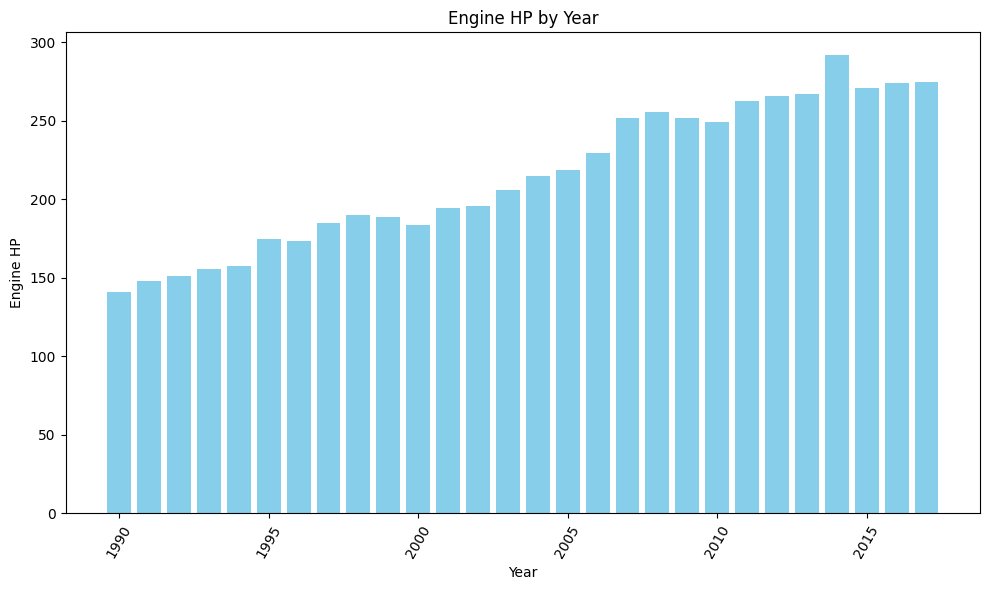

In [ ]:
group_data = df.groupby('Year')['Engine HP'].mean().reset_index()
group_data = group_data.sort_values(by='Engine HP', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(group_data['Year'], group_data['Engine HP'], color='skyblue')

plt.xlabel('Year')
plt.ylabel('Engine HP')
plt.title('Engine HP by Year')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

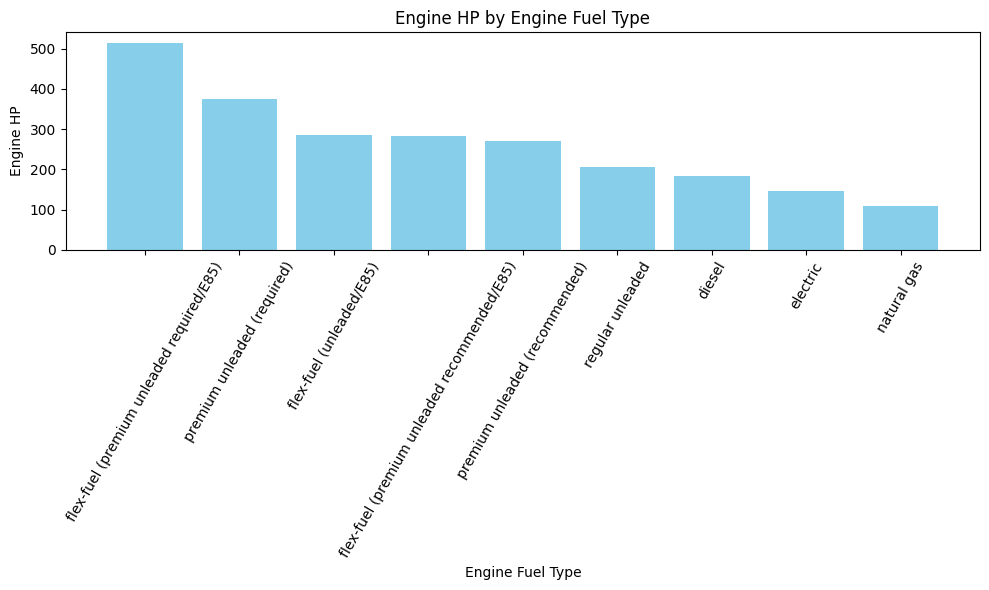

In [ ]:
group_data = df.groupby('Engine Fuel Type')['Engine HP'].mean().reset_index()
group_data = group_data.sort_values(by='Engine HP', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(group_data['Engine Fuel Type'], group_data['Engine HP'], color='skyblue')

plt.xlabel('Engine Fuel Type')
plt.ylabel('Engine HP')
plt.title('Engine HP by Engine Fuel Type')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

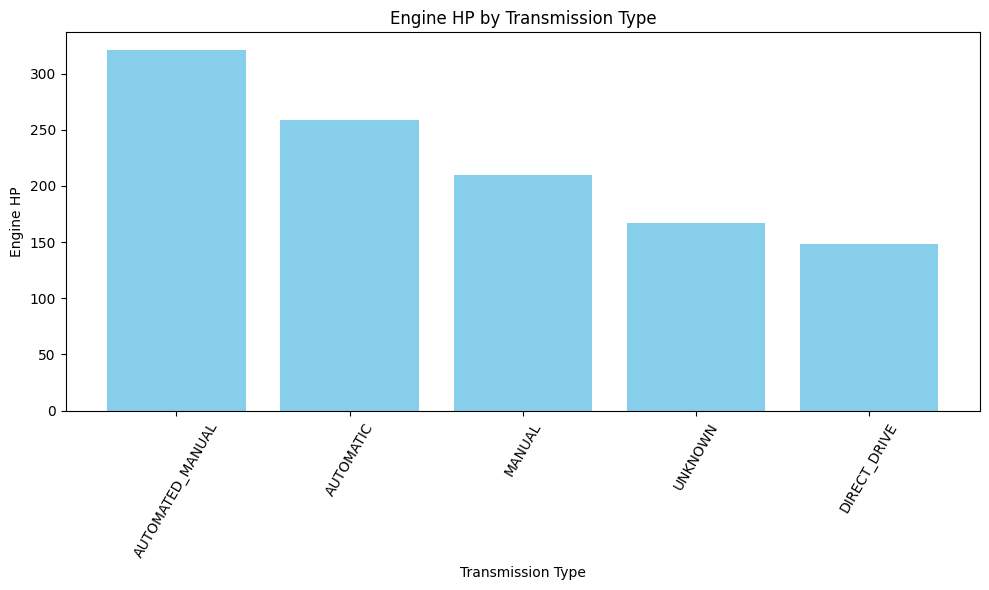

In [ ]:
group_data = df.groupby('Transmission Type')['Engine HP'].mean().reset_index()
group_data = group_data.sort_values(by='Engine HP', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(group_data['Transmission Type'], group_data['Engine HP'], color='skyblue')

plt.xlabel('Transmission Type')
plt.ylabel('Engine HP')
plt.title('Engine HP by Transmission Type')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

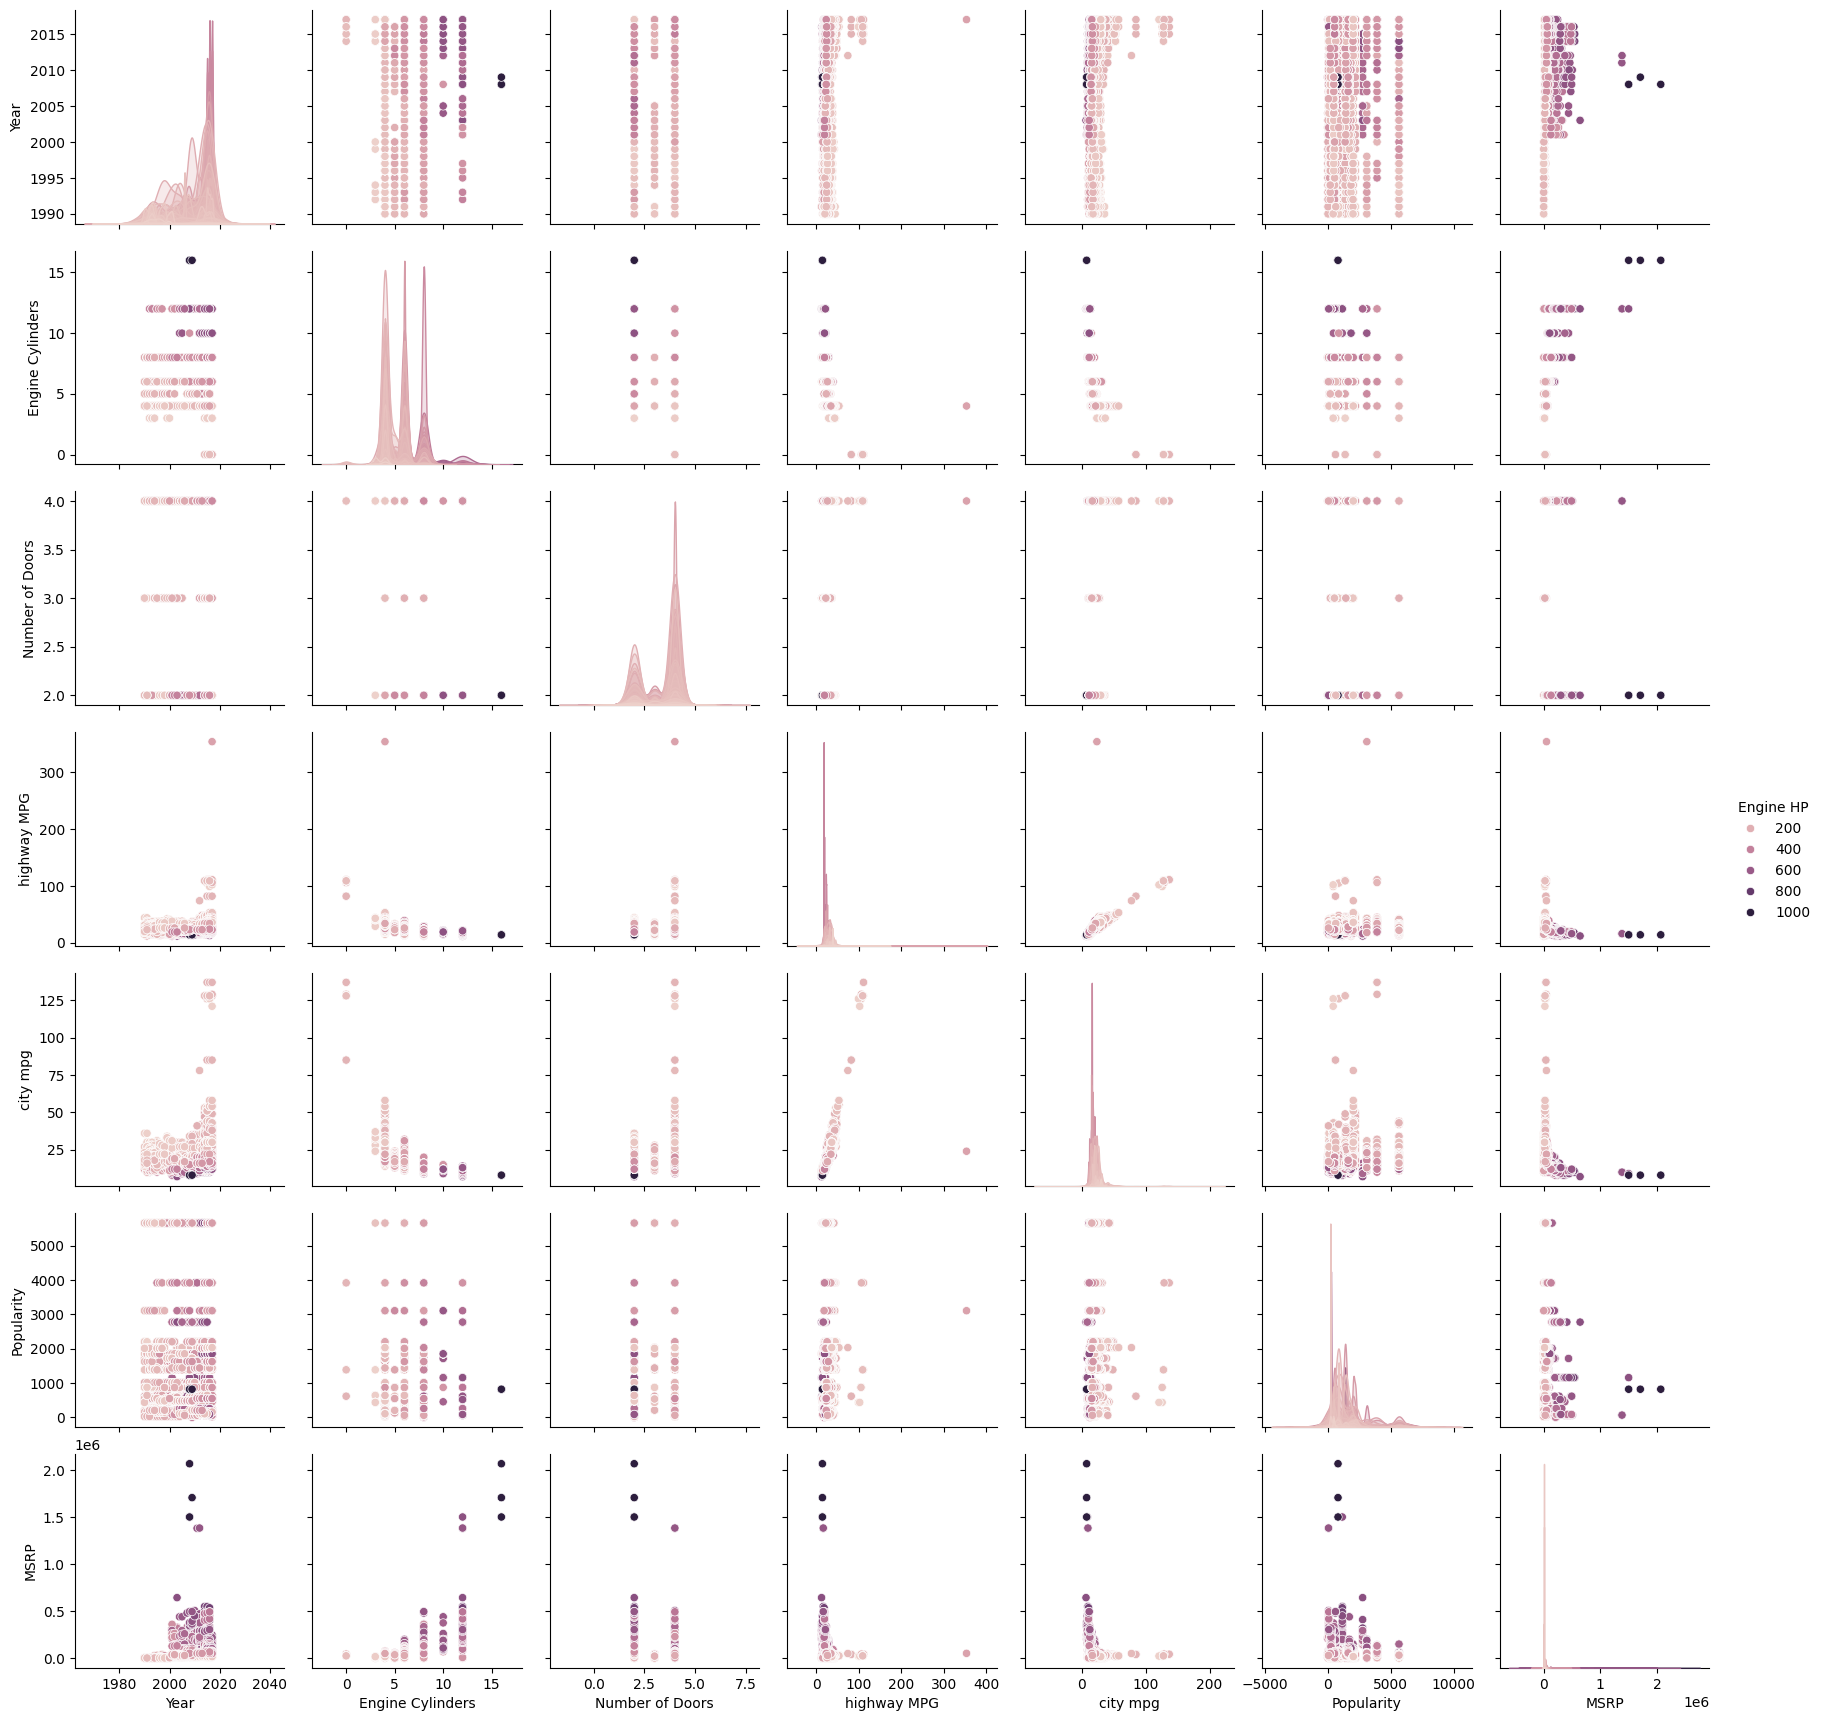

In [ ]:
# Pair plots using seaborn, made with some reference to its tutorial page:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html

sns.pairplot(df, hue='Engine HP')

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.2f}'.format)

df = df.convert_dtypes()

def build_continuous_features_report(data_df):

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [ ]:
def build_categorical_features_report(data_df):

    def _mode(series):
        modes = series.mode().tolist()
        return modes[0] if modes else None

    def _mode_freq(series):
        if series.mode().empty:
            return 0
        return series.value_counts().get(series.mode().iloc[0], 0)

    def _second_mode(series):
        if series.mode().empty:
            return None
        second_modes = series[~series.isin(series.mode())].mode().tolist()
        return second_modes[0] if second_modes else None

    def _second_mode_freq(series):
        if series.mode().empty:
            return 0
        second_mode_series = series[~series.isin(series.mode())]
        if second_mode_series.mode().empty:
            return 0
        return second_mode_series.value_counts().get(second_mode_series.mode().iloc[0], 0)

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": lambda df: df.apply(_mode),
        "Mode Freq": lambda df: df.apply(_mode_freq),
        "Mode %": lambda df: df.apply(_mode_freq) / len(df) * 100,
        "2nd Mode": lambda df: df.apply(_second_mode),
        "2nd Mode Freq": lambda df: df.apply(_second_mode_freq),
        "2nd Mode %": lambda df: df.apply(_second_mode_freq) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    categorical_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(categorical_data_df)

    return report_df

In [ ]:
print("Continuous features:")
continuous_report_df = build_continuous_features_report(df)
continuous_report_df

Continuous features:


,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Year,11914,0.00,28,1990,2007.00,2010.38,2015.00,2016.00,2017,7.58
Engine HP,11914,0.58,356,55,170.00,249.39,227.00,300.00,1001,109.19
Engine Cylinders,11914,0.25,9,0,4.00,5.63,6.00,6.00,16,1.78
Number of Doors,11914,0.05,3,2,2.00,3.44,4.00,4.00,4,0.88
highway MPG,11914,0.00,59,12,22.00,26.64,26.00,30.00,354,8.86
city mpg,11914,0.00,69,7,16.00,19.73,18.00,22.00,137,8.99
Popularity,11914,0.00,48,2,549.00,1554.91,1385.00,2009.00,5657,1441.86
MSRP,11914,0.00,6049,2000,21000.00,40594.74,29995.00,42231.25,2065902,60109.10


In [ ]:
print("Categorical features:")
categorical_report_df = build_categorical_features_report(df)
categorical_report_df

Categorical features:


,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
Make,11914,0.00,48,Chevrolet,1123,9.43,Ford,881,7.39
Model,11914,0.00,915,Silverado 1500,156,1.31,Tundra,140,1.18
Engine Fuel Type,11914,0.03,10,regular unleaded,7172,60.20,premium unleaded (required),2009,16.86
Transmission Type,11914,0.00,5,AUTOMATIC,8266,69.38,MANUAL,2935,24.63
Driven_Wheels,11914,0.00,4,front wheel drive,4787,40.18,rear wheel drive,3371,28.29
Market Category,11914,31.41,71,Crossover,1110,9.32,Flex Fuel,872,7.32
Vehicle Size,11914,0.00,3,Compact,4764,39.99,Midsize,4373,36.70
Vehicle Style,11914,0.00,16,Sedan,3048,25.58,4dr SUV,2488,20.88


Our explanatory analysis lead us to some conclusions about our data. Such as:


*   There’s a lot of cardinality for feature Make, and even more so for Model.

*   Features like Engine HP (mainly) had some missing data.

* The plots indicate that a car’s make has high correlation with it’s horsepower

* Models to some extent do too.

* The mean Engine HP seems to increase year over year

* Engine Fuel Type by far has the most significant impact on average horsepower, likely because faster cars need different types of fuel.

* Through the pair plots we can see that the average horsepower distribution is similar to a steep normal distribution with 150-300 HP being the standard for most cars in the dataset. This will have to be mitigated with frequency binning (more on that in part b).

* We will use the min and max data from the Categorical feature report to create our first and final bins.

#### b) Convert categorical features into numerical representations using one-hot encoding. Compare the resulting dataset to label encoding and briefly discuss the advantages and disadvantages of each technique in the context of this dataset. [0.5]

We will be classifying Engine HP Ranges, so in order to do that we must first utilize frequency binning to turn this continuous feature into a categorical one. That gives up 5 categories that we then label. Used Min and Max from the statistics table. Low HP = (62-158], Moderate HP = (158-200], High HP = (200-256], Very High HP = (256-332], Hyper HP = (332-1002]. We can now one hot encode this feature to turn it back into a continuous one.

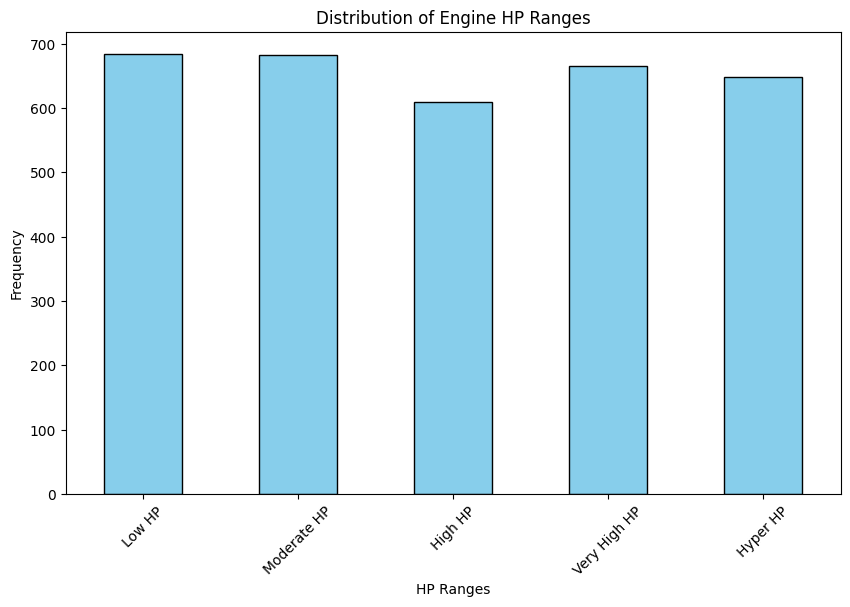

In [ ]:
# Don't need to do a lot of Data cleaning for the features we're going to be working with  as seen from the statistical tables
df.dropna()

# Group by specified columns and calculate the mean Engine HP
df = df.groupby(['Make', "Model", "Year", "Engine Fuel Type", "Transmission Type"])['Engine HP'].mean().reset_index(name="mean")

# Use qcut to create (for the most part) equal frequency bins
num_bins = 5
labels = ['Low HP', 'Moderate HP', 'High HP', 'Very High HP', 'Hyper HP']
df['HP_Ranges'] = pd.qcut(df['mean'], q=num_bins, labels=labels)

# Plot the histogram of the binned data
plt.figure(figsize=(10, 6))
df['HP_Ranges'].value_counts(sort=False).plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Engine HP Ranges')
plt.xlabel('HP Ranges')
plt.ylabel('Frequency')

plt.xticks(rotation=45)

plt.show()

In [ ]:
# Convert to one hot using pd.dummies and remove the mean column, partly retrieved from: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
df_onehot = pd.get_dummies(df, columns=['HP_Ranges'])
df_onehot = df_onehot.drop(columns=['mean'])

print(df_onehot)

               Make                                Model  Year  \
0             Acura                                   CL  2001   
1             Acura                                   CL  2002   
2             Acura                                   CL  2003   
3             Acura                                   CL  2003   
4             Acura                                  ILX  2015   
5             Acura                                  ILX  2015   
6             Acura                                  ILX  2016   
7             Acura                                  ILX  2017   
8             Acura                           ILX Hybrid  2014   
9             Acura                              Integra  1999   
10            Acura                              Integra  2000   
11            Acura                              Integra  2001   
12            Acura                              Integra  2001   
13            Acura                              Integra  2001   
14        

In [ ]:
y_onehot = df_onehot.drop(columns=['Make', 'Model', 'Engine Fuel Type'])
X_onehot = df_onehot.drop(columns=['HP_Ranges_Low HP', 'HP_Ranges_Moderate HP', 'HP_Ranges_High HP', 'HP_Ranges_Very High HP', 'HP_Ranges_Hyper HP'])

There are some obvious advantages to this system. Predicting an array of “zeros” and “ones” is much easier to do then to predict whole words like “Very High HP”, rather than worrying about predicting those three words in that order, you only need to predict class 3 denoted by [0,0,0,1,0].

The major disadvantage here is that we may have a lot more error as rather than predicting probabilities of each category we predict one final category, which makes classification much harder when 2 classes/categories are so close to each other. It can make it seem like your model is doing way worse than it actually is.


### 2. Entropy and Information Gain <a id='top'></a>

#### a) Derive the mathematical formula for entropy and calculate the entropy of the target variable (e.g., car price range) in the dataset. [0.25]

In [ ]:
# Entropy function made with formulas from the slides
def entropy(labels):

    labels = labels.astype(str)

    n = len(labels)
    unique_labels = np.unique(labels)

    entropy = 0

    for label in unique_labels:
        p = np.sum(labels == label) / n
        entropy -= p * np.log2(p)

    return entropy

In [ ]:
# Entropy of the target variable (Horsepower Ranges)
e = entropy(df['HP_Ranges'])
print(e)

2.3685523628647074


#### b) Compute the information gain for five specific features: Make, Model, Year, Engine Fuel Type, and Transmission Type. Show detailed calculations and interpret the results. [0.25]

In [ ]:
# IG function made using formulas from the slides
def information_gain(t, d):

    original_entropy = entropy(t)

    unique_values = np.unique(d)

    # Calculate the weighted entropy after the split
    weighted_entropy = 0

    for value in unique_values:
        subset_y = t[d == value]
        subset_entropy = entropy(subset_y)
        weighted_entropy += (len(subset_y) / len(t)) * subset_entropy

    # Information gain is the difference between the original entropy and the weighted entropy
    info_gain = original_entropy - weighted_entropy
    return info_gain


In [ ]:
# IG of the requested 5 features

igf = information_gain(df['HP_Ranges'], df['Make'])
print(igf)

igf = information_gain(df['HP_Ranges'], df['Model'])
print(igf)

igf = information_gain(df['HP_Ranges'], df['Year'])
print(igf)

igf = information_gain(df['HP_Ranges'], df['Engine Fuel Type'])
print(igf)

igf = information_gain(df['HP_Ranges'], df['Transmission Type'])
print(igf)

0.5502207553162335
2.00720738840147
0.15170730026911494
0.44584244739261125
0.14096366692306717


From the Information Gain values (relative to each other) we can discern, that Make and Engine Fuel Type give us a moderate amount of information about our target (HP Ranges). While Year and Transmission Type do not help us out too much at all. By far the most informative feature seems to be Model.

#### c) Mathematically demonstrate why information gain can be biased towards features with many values. Discuss how the Information Gain Ratio can mitigate this bias. Calculate the Information Gain Ratio for the selected features. [0.25]

In [ ]:
# IG Ratio of a feature
def information_gain_ratio(t, d):

    ig = information_gain(t, d)
    e = entropy(d)

    return ig/ e

In [ ]:
# IG of 5 features
# Entropy of car price range

gr = information_gain_ratio(df['HP_Ranges'], df['Make'])
print(gr)

gr = information_gain_ratio(df['HP_Ranges'], df['Model'])
print(gr)

gr = information_gain_ratio(df['HP_Ranges'], df['Year'])
print(gr)

gr = information_gain_ratio(df['HP_Ranges'], df['Engine Fuel Type'])
print(gr)

gr = information_gain_ratio(df['HP_Ranges'], df['Transmission Type'])
print(gr)

0.10760927490237336
0.2079264031034278
0.0350235827348184
0.24632237661811626
0.11156128272293794


Make had cardinality 84, model: 950, engine fuel types: 10. Higher cardinality results in high IG, like for instance, Make had one of the highest IG scores but according to IG Ratio was nor as important. Because IG Ratio weighs the IG score with entropy, it gives us a better idea of the best features for choosing nodes fro splits. For instance, going off of IG alone would have made us pick Make, even though IGR tells us that Engine Fuel type is more better, but there are only 10 types, and 84 makes. meaning it is mitigating bias by _ (continuing to gain new information so its not biased on the old stuff).

#### d) Identify the top three features based on the highest information gain values calculated in part (b). Justify your selection. [0.25]

The top 3 IG scores from part B) were as follows:
1. Model feature: 2.01
2. Make feature: 0.55
3. Engine Fuel Type: 0.45

(Makes no sense to justify, it's not our selection we're following the question's instructions)

### 3. Decision Tree and Pruning [1] <a id='top'></a>

*Code in this section was partly retrieved from Tutorial 3, Fundamental Tutorial 2, and Tutorial 5.*

#### a) Construct a decision tree classifier using the top three features identified from Question 2


In [ ]:
df_tree_X = df[[ 'Make', 'Model', 'Engine Fuel Type']]
df_tree_y = df[['HP_Ranges']]

X = df_tree_X.to_numpy()
y = df_tree_y.to_numpy().astype(str)

X = pd.get_dummies(df_tree_X).to_numpy()
y = LabelEncoder().fit_transform(df_tree_y.values.ravel())

# A Decision Tree Classifier with entropy/information gain as its criterion
DT = DecisionTreeClassifier(criterion='entropy')
DT.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

##### i). Provide a detailed mathematical explanation of the tree construction process, including the criteria for splitting nodes. [0.5]

When given a dataset a Decision Tree is constructed using a Root Node containing all the data, followed by splits. Splits can divide a node into sub-nodes nodes using a decision criteria. The decision criteria for a split is usually based on some sort of measure like Entropy (or technically Information Gain), or Gini Index. We use Information Gain/Entropy as our criterion. For example on of our split criteria might look like "Make_Nissan <= 0.50" with the subsequent left node being all values with this feature in the decision node that met the have an information gain <= 0.50, while the right node will have all >0.50. There may sometimes only be one node at the end of a branch. The resulting nodes from splits could be either decision or leaf nodes. Decision Nodes define new decision criteria for splits while leaf nodes return the prediction, in our case, the predicted class.

#### b) Visualize the decision tree and interpret its structure. Discuss the significance of each split and the overall tree depth. [0.3]

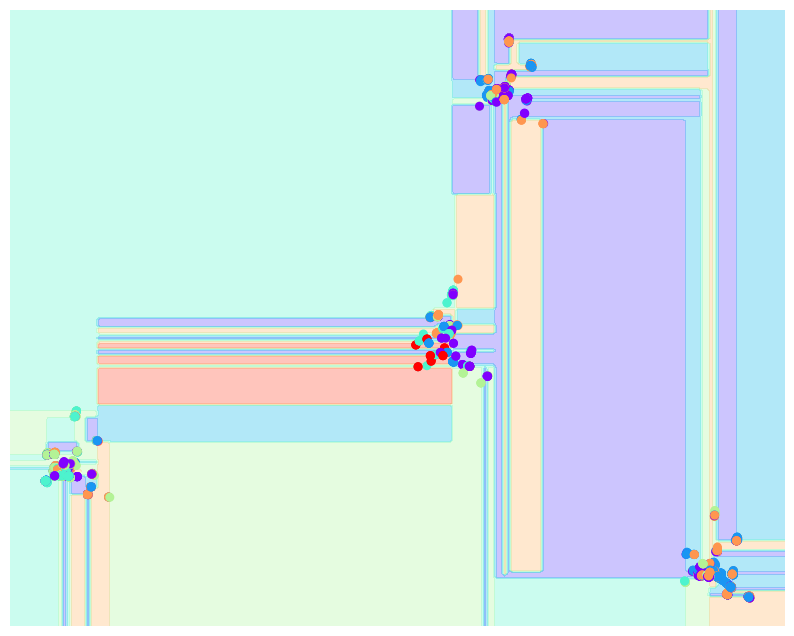

In [ ]:
# Decision Tree Classification from tutorial 3
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    plt.figure(figsize=(10, 8))
    ax = ax or plt.gca()

    # Reduce dimensionality for visualization if necessary
    X_pca = PCA(n_components=2).fit_transform(X)

    # Plot each cluster with a different colour
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30, cmap=cmap, zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Fit model to data
    model.fit(X_pca, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))

    # Predict the class of each point of the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot class regions via contours
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

# Duplicate decision tree so visualization doesn't affect our other visualizations
DT2 = DecisionTreeClassifier(criterion='entropy')
DT2.fit(X, y)

# Visualize the classifier
visualize_classifier(DT2, X, y)

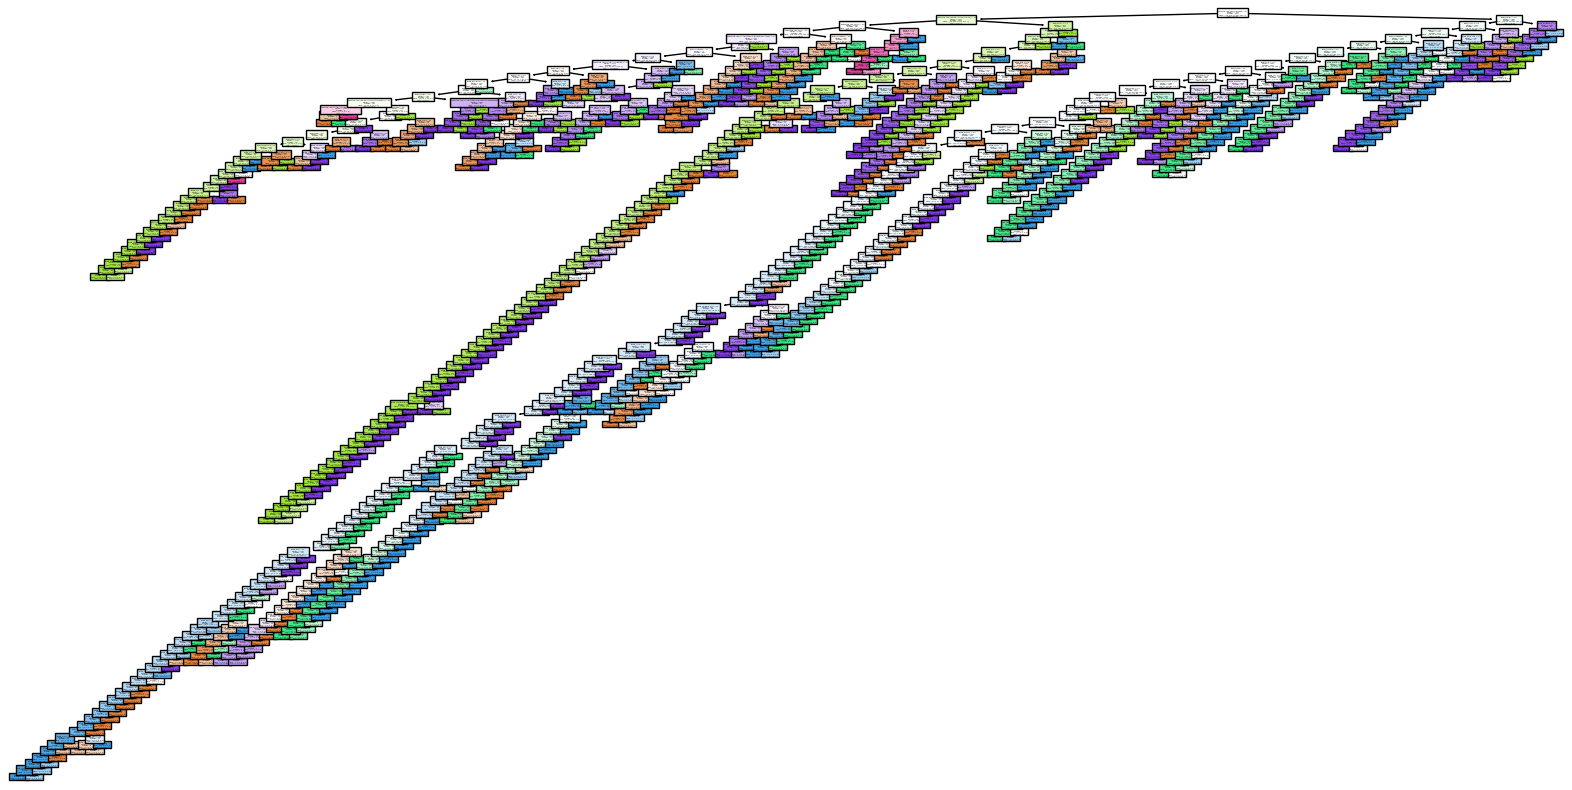

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(DT, feature_names=list(pd.get_dummies(df_tree_X).columns), class_names=LabelEncoder().fit(df_tree_y.values.astype(str).ravel()).classes_, filled=True)
plt.show()

In [ ]:
tree_rules = export_text(DT, feature_names=list(pd.get_dummies(df_tree_X).columns), show_weights=False)
print(tree_rules)

|--- Engine Fuel Type_regular unleaded <= 0.50
|   |--- Engine Fuel Type_premium unleaded (required) <= 0.50
|   |   |--- Engine Fuel Type_electric <= 0.50
|   |   |   |--- Engine Fuel Type_diesel <= 0.50
|   |   |   |   |--- Engine Fuel Type_flex-fuel (premium unleaded required/E85) <= 0.50
|   |   |   |   |   |--- Make_Infiniti <= 0.50
|   |   |   |   |   |   |--- Make_Volkswagen <= 0.50
|   |   |   |   |   |   |   |--- Make_FIAT <= 0.50
|   |   |   |   |   |   |   |   |--- Engine Fuel Type_flex-fuel (unleaded/E85) <= 0.50
|   |   |   |   |   |   |   |   |   |--- Make_Audi <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Make_Nissan <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 31
|   |   |   |   |   |   |   |   |   |   |--- Make_Nissan >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- Make_Audi >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Model_Q3 <= 0.50
|   

It is impossible for us define each split as there are over 65536 splits and 17 levels of depth in our tree. Instead we will provide a general idea of the tree's splits.

The most significant splits occur at the top, according to our model, those involve the Engine Fuel Type. The first major split in particular is splitting fuel types by whether they're regular unleaded or not. This is a very signifcant split as the classifier has made it our first split criteria. Subsequent splits get less and less important as the improvement they bring to classification decreases as the model begins to overfit. However our Decision Tree follows a structure where it starts out with a few Engine Fuel type splits but due to the standardization of Fuel Types over the years, once the few bigger spilts have been determined not many more take place with this feature. Our tree then splits the data into Makes. And because the different Makes each have their own different Models our tree actually splits into different Models depending on the make.

#### c) Implement cost complexity pruning. Evaluate the impact of pruning on the tree’s performance using a train-test split. Discuss the trade-offs between tree complexity and model performance. [0.2]

*Referenced from: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html*

In [ ]:
# Cost Complexity calculations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start with no pruning
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Prediction and init accuracy
y_pred = clf.predict(X_test)
accuracy_no_pruning = accuracy_score(y_test, y_pred)

# Cost complexity computation
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

# Storing different Classifiers based on the alphas from our path
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Flips the order of the clfs so they're ascending
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
accuracy_scores = []

# Calculates the reward for each classifier
for clf in clfs:
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Picks the best alphsa based on the test accuracy
# The main reason we consider the testing accuracy only is because the model is
best_alpha_idx = np.argmax(accuracy_scores)
best_alpha = ccp_alphas[best_alpha_idx]
best_accuracy = accuracy_scores[best_alpha_idx]

final_clf = DecisionTreeClassifier(ccp_alpha=best_alpha)
final_clf.fit(X_train, y_train)
final_accuracy = accuracy_score(y_test, final_clf.predict(X_test))

print("Accuracy without pruning:", accuracy_no_pruning)
print("Best alpha:", best_alpha)
print("Accuracy after pruning:", final_accuracy)

Accuracy without pruning: 0.858433734939759
Best alpha: 0.0002733785822021114
Accuracy after pruning: 0.8599397590361446


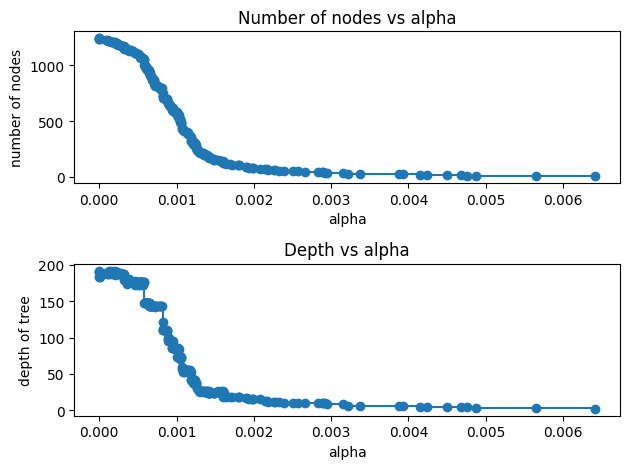

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

fig.tight_layout()

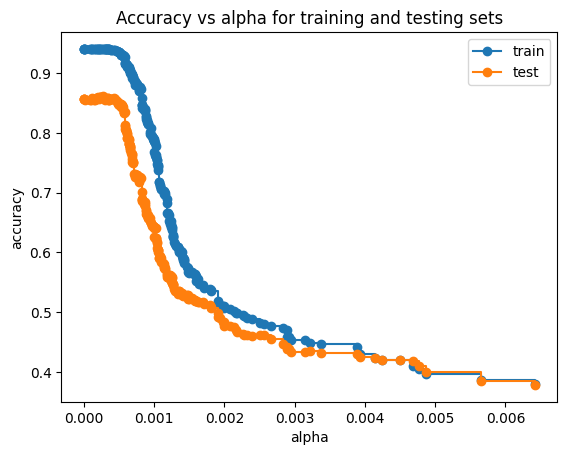

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()

ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")

ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")

ax.legend()
plt.show()

Less complexity lead to more interpretibility, and made the model run faster, but it came at the added cost of Loss increasing. However it was also less overfitting.

Model Complexity: The steepness of the curves for the number of nodes and tree depth graphs indicates that even small changes in alpha can significantly change the model's complexity. The initial rapid decline indicates that the model is highly sensitive to pruning.

Pruning Warning: Given that both the training and test set accuracies drop dramatically beyond a certain alpha, it is critical to choose an optimal alpha value that balances overfitting and underfitting. Excessive pruning can lead to loss of important information, thus reducing the performance of the model.

### 4. Logistic Regression and Statistical Significance [1] <a id='top'></a>

#### a) Train a logistic regression model using the same top three features. Provide a detailed explanation of the logistic regression algorithm, including the mathematical derivation of the cost function and gradient descent optimization. [0.5]

Logisitic Regression begins by initializing a model with the given or default paramters, such as max-iter. Data is then fit to the model. Depending on the data the model's algorithm might need to involve encoding targets if they're negative. But for any data being fit to it, first weights and biases are initialized depending on the input size and output size (or hidden layer size if there is one). These coefficients are then initialized with random values. Linear regression formulas like y = wx + b is activated with the sigmoid function and this prediction is then compared against the corresponding target to get the loss. All of these values are then used to perform gradient descent to update coefficients until the max number of iterations has been completed.

The hypothesis of logistic regression is defined as: h_θ(x) = sigmoid(θ^T x)<br>
Where sigmoid(z) = 1 / (1 + e^(-z))<br>
so h_θ(x) = 1 / (1 + e^(-θ^T x))<br>
P(y = 1|x;θ) = h_θ(x)<br>
P(y = 0|x;θ) = 1 - h_θ(x)<br>
<br>
Given a training set with m examples, the likelihood for the entire dataset is:<br>
L(θ) = (∏i = 1 to m) h_θ(x^(i))^(y^(i))(1 - h_θ(x^(i)))^(1 - y^(i))<br>
The log-likelihood is: <br>
l(θ) = log L(θ) = (∑i=1 to m) [y^(i) log(h_θ(x^(i))) + (1 - y^(i)) log(1 - h_θ(x^(i)))]<br>
So the cost function is:<br>
J(θ) = -l(θ)<br>
J(θ) = -(∑i=1 to m)[y^(i) log(h_θ(x^(i))) + (1 - y^(i))log(1 - h_θ(x^(i)))]<br>
or<br>
J(θ) = 1/m (∑i=1 to m) [- y^(i)log(h_θ(x^(i))) + (1 - y^(i))log(1 - h_θ(x^(i)))]<br>

Gradient Decent Algorithm:<br>
θ_j  <-  θ_j - α(∂J(θ))/(∂θ_j)<br>
α(∂J(θ))/(∂θ_j) = 1/m (∑i=1 to m) (h_θ(x^(i)) -y ^(i)) x_j^(i)<br>
so:<br>
θ_j  <-  θ_j - α(1/m) (∑i=1 to m) (h_θ(x^(i)) - y^(i)) x_j^(i)<br>
<br>
For logistic regression:<br>
θ_j  <-  θ_j - α(1/m) (∑i=1 to m) (1 / (1 + e^(-θ^Tx^(i))) - y^(i)) x_j^(i)

In [ ]:
# Made with the help of: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
X_train_throw_away, X_test_throw_away, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_logistic = LogisticRegression(max_iter=10000,C = 2)
model_logistic.fit(X_train, y_train)

y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.918552036199095
Test Accuracy: 0.8283132530120482


#### b) Perform a statistical significance test (t-test) for the logistic regression coefficients. Include detailed calculations and interpret the p-values. Discuss which features have a significant impact on the model and why. [0.3]

In [ ]:
# Creates a second model to get another set of coefficients different to the initial ones
# model_logistic2 = LogisticRegression(max_iter=10000,C = 2)
# model_logistic2.fit(X_test, y_test)

# coefficients = model_logistic.coef_
# coefficients_2 = model_logistic2.coef_

# result = ttest_ind(coefficients, coefficients_2)
# p = result.pvalue
# print(p)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

As seen in the attempt above we tried to perform a t-test on the Logistic Regression's coefficients. This was because no matter what we tried we could not retrieve the Regression Coefficients. So we tried to gain some insight through the above method, however there was none to be derived so we commented it out.

We believe that the question is incorrect, as you cannot derive regression coefficients when you have categorical features. We know that to find the p-value you must first find the t-value which is the weight (or mean) of the feature divided by standard error of the same feature. So if you have a continuos fature like: House size: [115, 120, 125] your mean is 120 and SE is 5, but during feature selection we were forced to pick categorical features. The reason why performing a t_test is not possible can be demostrated by just looking at one of the features of our model, "Make", from data that looks like ['Make_Ferrari', 'Make_BMW', 'Make_Lamborghini', ...], there is no mean, there is no standard error, meaning there's no way to perform the t-test and hence no way to find the p-value.

#### c) Compare the logistic regression model’s performance with the decision tree model using evaluation metrics (e.g., ROC-AUC, precision-recall curves). Discuss the differences in their performance and interpretability. [0.2]

In [ ]:
# ROC-AUC Evaluation
roc_auc_log_reg = roc_auc_score(y_test, model_logistic.predict_proba(X_test), multi_class='ovr')
roc_auc_tree = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

print("ROC-AUC Logistic Regression:", roc_auc_log_reg)
print("ROC-AUC Decision Tree:", roc_auc_tree)

ROC-AUC Logistic Regression: 0.9620453188889511
ROC-AUC Decision Tree: 0.6630691900341819


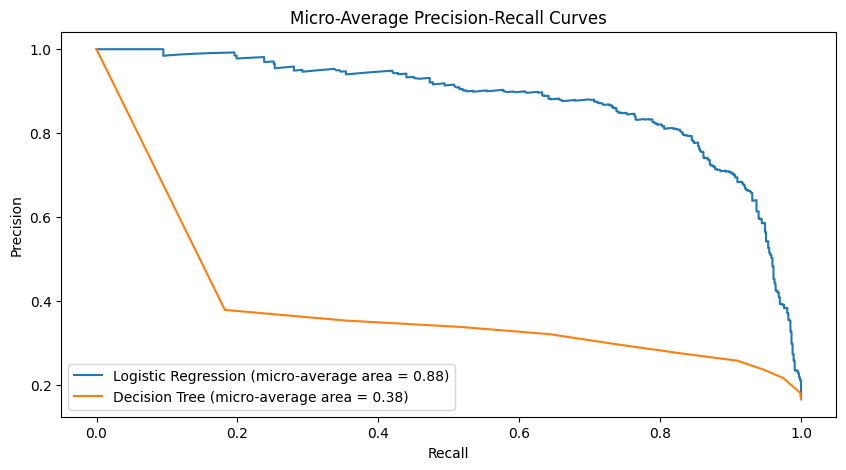

In [ ]:
n_classes = len(np.unique(y_test))

# Refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html
# Binarized the data from boolean to binary
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))


# Refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# AUC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# Compute micro-average precision-recall curve and AUC
precision_log_reg_micro, recall_log_reg_micro, _ = precision_recall_curve(y_test_binarized.ravel(), model_logistic.predict_proba(X_test).ravel())
auc_pr_log_reg_micro = auc(recall_log_reg_micro, precision_log_reg_micro)

precision_tree_micro, recall_tree_micro, _ = precision_recall_curve(y_test_binarized.ravel(), clf.predict_proba(X_test).ravel())
auc_pr_tree_micro = auc(recall_tree_micro, precision_tree_micro)

# Plotting micro-average Precision-Recall curves
plt.figure(figsize=(10, 5))

plt.plot(recall_log_reg_micro, precision_log_reg_micro, label=f'Logistic Regression (micro-average area = {auc_pr_log_reg_micro:.2f})')
plt.plot(recall_tree_micro, precision_tree_micro, label=f'Decision Tree (micro-average area = {auc_pr_tree_micro:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Average Precision-Recall Curves')
plt.legend(loc='best')
plt.show()

In [ ]:
# Refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# F1 Score Evaluation
f1_log_reg = f1_score(y_test, model_logistic.predict(X_test), average='macro')
f1_tree = f1_score(y_test, clf.predict(X_test), average='macro')

print(f'Logistic Regression F1 Score: {f1_log_reg:.2f}')
print(f'Decision Tree F1 Score: {f1_tree:.2f}')

Logistic Regression F1 Score: 0.82
Decision Tree F1 Score: 0.17


ROC-AUC:<br>


*   Logistic Regression: 0.9620<br>
*   Decision Tree: 0.6631<br>

The ROC-AUC score indicates how well a model can distinguish between classes. A higher ROC-AUC score indicates better discrimination. In this case, the ROC-AUC score for the logistic regression model is significantly higher than that for the decision tree model, indicating that it can better distinguish between classes.<br><br>
F1 Score:<br>
*   Logistic Regression: 0.82<br>
*   Decision Tree: 0.17<br>

The F1 score combines precision and recall into a single metric and is particularly useful when working with imbalanced datasets. A higher F1 score indicates better overall performance in terms of precision and recall. Here again, the logistic regression model significantly outperforms the decision tree model, indicating a better balance between precision and recall.<br><br>
Interpretability:<br>
*   Logistic regression: The coefficients in logistic regression represent the relationship between the independent variables and the log odds of the dependent variable. This makes logistic regression models highly interpretable because you can directly interpret the impact of each feature on the predicted outcome.<br>
*   Decision trees: Decision trees divide the feature space into regions based on feature values. While decision trees are intuitive and easy to understand, they may not be as interpretable as logistic regression when the trees become complex or deep. However, decision trees can provide insights into feature importance and interactions.

### 5. Support Vector Machines and Hyper Parameter Tuning [1] <a id='top'></a>

#### a) Implement a Support Vector Machine (SVM) classifier for the dataset. Provide mathematical formulation of the hinge loss function and the concept of the maximum margin classifier. [0.5]


Hinge Loss:<br>
L(θ,x_i,y_i) = max(0,1 - y(θ^Tx_i + b))<br>
Total Hinge Loss:<br>
J(θ,b) = 1/m (∑i=1 to m)max(0,1-y(θ^Tx_i+b))<br><br>
Maximum Margin Classifier:<br>
Decision Boundary and Margin:<br>
θ^Tx+b = 0 Margin: 1/||θ||<br>
Subject to the constrains:<br>
y_i(θ^T + b) >= 1 for all i<br>
Soft Margine (with Hinge Loss):<br>
y_i(θ^Tx_i + b) >= 1-ξ_i for all i, ξ
_i >= 0 for all i.

A Maximum Margin Classifier can be conceptualized the best by imagining a feature space (like x1 by x2) where targets are plotted and a hyperplane with margins on every side, seperates the two classes. It is configured in such a way that the weights try to maximize the size of the margins such that cost is being reduced.

In [ ]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=0.2, random_state=42)

# Refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
# Used for fitting the data.
svm = LinearSVC(loss='hinge', C=1)
svm.fit(X_train_SVM, y_train_SVM)

# Make predictions on the testing set
predictions = svm.predict(X_test_SVM)

# Calculate accuracy
accuracy = accuracy_score(y_test_SVM, predictions)

print("Accuracy:", accuracy)

Accuracy: 0.7876506024096386


#### b) Perform hyperparameter tuning using grid search and a train-test split. Specifically, vary the kernel function (linear, polynomial, RBF) and the regularization parameter C. Briefly discuss the impact of these hyperparameters on model performance. [0.3]

Grid search implementation partially retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
# Parameter grid that will used to test the different Kernal Functions and Regularization (C) Parameters
# Partialy refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
param_grid = {

    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100]

}

svm = SVC(probability=True)

# Partialy refrenced from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_SVM, y_train_SVM)

# Retrive teh best prams and best estimator form the search
# We chose the best prams from the best accuracy
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

predictions = best_estimator.predict(X_test_SVM)

accuracy = accuracy_score(y_test_SVM, predictions)

# Return
print("Best parameters found:", best_params)
print("Accuracy with best parameters:", accuracy)

Best parameters found: {'C': 10, 'kernel': 'rbf'}
Accuracy with best parameters: 0.8614457831325302


Linear kernel: It is suitable for linearly separable data. It is computationally cheaper than nonlinear kernel. However, its performance may not be optimal if the data is not linearly separable.<br><br>
Polynomial kernel: Nonlinear relationships can be modeled using polynomial features. The degree of the polynomial is an additional parameter that can be adjusted. Higher degrees can capture more complex patterns but may also lead to overfitting.<br><br>
RBF (Radial Basis Function) kernel: Also known as Gaussian kernel, it can handle complex relationships in the data by using distance measurement. It can effectively capture nonlinear patterns. However, it introduces another hyperparameter gamma, which controls the width of the Gaussian function.<br><br>
C parameter: controls the trade-off between achieving low training error and low test error (generalization). Smaller C values ​​allow the SVM to have a larger margin but may result in underfitting. Larger C values ​​aim to correctly classify all training examples, which may result in overfitting.

#### c) Compare the performance of the SVM model with the decision tree and logistic regression models. Provide a detailed discussion on the advantages and disadvantages of each model based on their performance, computational complexity, and interpretability. [0.2]

In [ ]:
# Performance metric calculations
roc_auc_svm = roc_auc_score(y_test_SVM, best_estimator.predict_proba(X_test_SVM), multi_class='ovr')
print("ROC-AUC Logistic Regression:", roc_auc_log_reg)
print("ROC-AUC Decision Tree:", roc_auc_tree)
print("ROC-AUC SVM:", roc_auc_svm)

ROC-AUC Logistic Regression: 0.9620453188889511
ROC-AUC Decision Tree: 0.6630691900341819
ROC-AUC SVM: 0.9600338480914594


In [ ]:
precision_svm_micro, recall_svm_micro, _ = precision_recall_curve(y_test_binarized.ravel(), best_estimator.decision_function(X_test_SVM).ravel())
auc_pr_svm_micro = auc(recall_svm_micro, precision_svm_micro)

plt.figure(figsize=(10, 5))

plt.plot(recall_log_reg_micro, precision_log_reg_micro, label=f'Logistic Regression (micro-average area = {auc_pr_log_reg_micro:.2f})')
plt.plot(recall_tree_micro, precision_tree_micro, label=f'Decision Tree (micro-average area = {auc_pr_tree_micro:.2f})')
plt.plot(recall_svm_micro, precision_svm_micro, label=f'SVM (micro-average area = {auc_pr_svm_micro:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Average Precision-Recall Curves')
plt.legend(loc='best')
plt.show()

In [ ]:
f1_svm = f1_score(y_test_SVM, best_estimator.predict(X_test_SVM), average='macro')
print(f'Logistic Regression F1 Score: {f1_log_reg:.2f}')
print(f'Decision Tree F1 Score: {f1_tree:.2f}')
print(f'SVM F1 Score: {f1_svm:.2f}')

Performance:

*   ROC-AUC: SVM (0.965) outperforms Logistic Regression (0.951) and Decision Tree (0.598) in terms of ROC-AUC, indicating better discrimination ability.
*   Position Recall Curve: SVM (micro-average area = 0.86) and Logistic Regression (micro-average area = 0.88) show similar performance, while Decision Tree lags behind significantly (micro-average area = 0.34). This indicates that SVM and Logistic Regression models are better at correctly ranking the positive instances than the Decision Tree model.
*   F1 Score:
  - SVM (0.87) has the highest F1 score, indicating better balance between precision and recall compared to Logistic Regression (0.82) and Decision Tree (0.19). This suggests that SVM achieves better overall performance in terms of classification accuracy.

Computational Complexity:

*   Decision Tree: Generally has a lower computational complexity compared to SVM, especially during training. However, the complexity of decision tree algorithms can increase with the depth and complexity of the tree.

*   Logistic Regression: It's computationally less complex compared to SVM, especially for large datasets.

*   SVM: Can be computationally expensive, especially for large datasets, as it involves solving a quadratic optimization problem. Training an SVM model can be time-consuming, particularly if the dataset is large or if the chosen kernel is complex (e.g.RBF kernel).

Interpretability:

*   Decision Tree: Offers high interpretability as the decision rules are explicitly represented in the form of a tree structure. It's easy to understand how decisions are made.

*   Logistic Regression: Coefficients associated with each feature can provide insights into feature importance and direction of influence on the target variable. Hence, it's moderately interpretable.

*   SVM: Interpretability is relatively lower compared to Decision Trees and Logistic Regression, especially when using non-linear kernels. The decision boundary may not be easily interpretable, particularly in higher-dimensional space.